In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import linregress
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation
from IPython import display
from IPython.display import display, HTML
from scipy.interpolate import interp1d
from matplotlib import animation, rc
rc('animation', html='html5')
from IPython.display import HTML, Image
from itertools import groupby
# from easing import easing
%load_ext autoreload
%autoreload 2
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import FuncFormatter
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.image as mpimg
from PIL import Image, ImageDraw, ImageFont


In [2]:
#####you are currently working on incorporating size into easing.  Size can move liniarly nbd so creating a size adjustment function should be no big deal but
##currently having trouble figuring out how to pass it with the dataframe that gets passed to the easing funciton.  may need to pass it a second df with the size array.
##actually, figure out clusters and color.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import animation, rc
rc('animation', html='html5')
from IPython.display import HTML, Image
from itertools import groupby
from matplotlib.ticker import FormatStrFormatter



class Eased:
    """ This class takes the original time vector and raw data (as a m*n matrix or dataframe) along with an output vector and interpolation function
    For the input data, the rows are the different variables and the columns correspond to the time points"""

    def __init__(self, data,data_y=None, in_t=None):

        if isinstance(data, pd.DataFrame):
            self.labels=np.append(data.index.values,np.array([data.index.values[0],data.index.values[0]]))
            self.int_t = np.arange(len(self.labels)-1)


            self.data = np.vstack((data.values,data.values[0,:]))
            self.n_dims = data.shape[1]
            self.columns=data.columns
        elif isinstance(data, np.ndarray):
            if in_t is None:
                in_t=np.arange(np.shape(data)[0])
                print("No time vector included - defaulting to number of rows")

            self.int_t = in_t
            self.data = data
            self.n_dims = len(np.shape(data))
        else:
            print('\033[91m' + "Data is unrecognized type : must be either a numpy array or pandas dataframe")


    def No_interp(self,smoothness=10):
        out_t=np.linspace(min(self.int_t),max(self.int_t),len(self.int_t)*smoothness)
        self.n_steps = int(np.ceil(len(out_t) / len(self.int_t)))
        self.out_t = out_t

        #This Function maps the input vecotor over the outuput time vector without interoplation
        if self.n_dims == 1: # if the input is only one row
            self.eased = np.zeros((len(self.out_t), 1))
            for i, t in enumerate(self.out_t):
                self.eased[i] = self.data[int(np.floor(i / self.n_steps))]
        else: #if the input is a multidimensional row
            self.eased = np.zeros((np.shape(self.data)[0], len(self.out_t)))
            for z in range(np.shape(self.data)[0]):
                for i, t in enumerate(self.out_t):
                    self.eased[z, i] = self.data[z, int(np.floor(i / self.n_steps))]

        return self.eased

    def power_ease(self, n,smoothness=10):
        out_t=np.linspace(min(self.int_t),max(self.int_t),len(self.int_t)*smoothness)
        self.n_steps = int(np.ceil(len(out_t) / len(self.int_t)))
        self.out_t = out_t
        sign = n % 2 * 2
        if self.n_dims == 1:
            self.eased = np.zeros((len(self.out_t), 1))
            j = 0
            for i in range(len(self.int_t) - 1):

                start = self.data[i]
                end = self.data[i + 1]
                for t in np.linspace(0, 2, self.n_steps):
                    if (t < 1):
                        val = (end - start) / 2 * t ** n + start

                    else:
                        t -= 2
                        val = (1 - sign) * (-(end - start) / 2) * (t ** n - 2 * (1 - sign)) + start

                    self.eased[j] = val
                    j += 1
            self.eased[j:] = self.data[i + 1]

        else:
            self.eased = np.zeros(( len(self.out_t),np.shape(self.data)[1]))
            for z in range(np.shape(self.data)[1]):
                j = 0
                for i in range(len(self.int_t) - 1):

                    start = self.data[ i,z]
                    end = self.data[ i + 1,z]
                    for t in np.linspace(0, 2, self.n_steps):
                        if (t < 1):
                            val = (end - start) / 2 * t ** n + start

                        else:
                            t -= 2
                            val = (1 - sign) * (-(end - start) / 2) * (t ** n - 2 * (1 - sign)) + start

                        self.eased[ j,z] = val
                        j += 1
                self.eased[ j:,z] = self.data[ i + 1,z]

        return self.eased


    def scatter_animation2d(self,n=3,smoothness=30,speed=1.0,gif=False,destination=None,plot_kws=None,label=False,dot_colors=None, bub_size=None, background_image_path=None):
        """
        Flexibly create a 2d scatter plot animation.

        This function creates a matplotlib animation from a pandas Dataframe or a MxN numpy array. The Columns are paired
        with x and y coordinates while the rows are the individual time points.

        This takes a number of parameters for the animation, as well as


        Parameters
        ----------
        n: Exponent of the power smoothing
        smoothness: how smooth the frames of the animation are
        speed: speed
        inline:
        gif:
        destination:
        :return:
        """


        #Running checks on data for mishappen arrays.
        if np.shape(self.data)[1]%2!=0:
            print('\033[91m' + "Failed: Data must have an even number of columns")
            exit()
        if np.shape(self.data)[0]<np.shape(self.data)[1]:
            print('\033[91m' + "Warning : Data has more columns (xys) than rows (time)")


        if plot_kws is None:
            plot_kws = dict()


        it_data=self.power_ease(n,smoothness)
        

        # filling out missing keys
        vanilla_params={'s':10,'color':'black','xlim':[np.min(it_data)-1, np.max(it_data)*1.1],'ylim':[np.min(it_data)-1,np.max(it_data)*1.11],'xlabel':'','ylabel':'','alpha':1.0,'figsize':(6,6)}
        for key in vanilla_params.keys():
            if key not in plot_kws.keys():
                plot_kws[key] = vanilla_params[key]

        fig, ax = plt.subplots(figsize=plot_kws['figsize'])
        ax.set_xlim(plot_kws['xlim'])
        ax.set_ylim(plot_kws['ylim'])
        ax.set_xlabel(plot_kws['xlabel'])
        ax.set_ylabel(plot_kws['ylabel'])
        ax.xaxis.set_major_formatter(plot_kws['xaxis_format'])
        ax.yaxis.set_major_formatter(plot_kws['yaxis_format'])

        if background_image_path is not None:
            bg_img = plt.imread(background_image_path)
            plt.imshow(bg_img, extent=[plot_kws['xlim'][0], plot_kws['xlim'][1], plot_kws['ylim'][0], plot_kws['ylim'][1]], aspect='auto')
        
        if label==True:
            label_text = ax.text(plot_kws['xlim'][1]*0.75, plot_kws['ylim'][1]*.9, '',fontsize=18)

        n_dots = int(np.shape(self.data)[1] / 2)
        dots = []
        

#         for i in range(n_dots):
#             dot = ax.scatter([], [], s=plot_kws['s'], color=plot_kws['color'], alpha=plot_kws['alpha'])
#             dots.append(dot)

            
        for i in range(n_dots):
            dot_color = dot_colors[i] if dot_colors is not None else plot_kws.get('color', 'black')
            size = bub_size[i] if bub_size is not None else plot_kws.get('s', 10)
            dot = ax.scatter([], [], s=size, color=dot_color, alpha=plot_kws['alpha'],)
            dots.append(dot)
            
        def animate(z):
            for i in range(n_dots):
                dots[i].set_offsets(np.column_stack((it_data[z, i * 2], it_data[z, i * 2 + 1])))
            if label==True:
                label_text.set_text(self.labels[int(np.floor((z+smoothness/2)/smoothness))])
                return dots,label_text
            else:
                return dots

        anim = animation.FuncAnimation(fig, animate, frames=len(self.out_t),interval=400/smoothness/speed, blit=False)
        
        video = anim.to_html5_video()
        html = display(HTML(video))

        display(html)


        if destination is not None:
            if destination.split('.')[-1]=='mp4':
                writer = animation.writers['ffmpeg'](fps=60)
                anim.save(destination, writer=writer, dpi=100)
            if destination.split('.')[-1]=='gif':
                anim.save(destination, writer='imagemagick', fps=smoothness)

        if gif==True:
            return Image(url='animation.gif')
        else:
            return anim





    def barchart_animation(self,n=3,smoothness=30,speed=1.0,gif=False,destination=None,plot_kws=None,label=False,zero_edges=True,loop=True):
        '''
        This barchart animation create line barcharts that morph over time using the eased data class

        It takes the following additional arguments
        :param n: this is the power curve modifier to passed to power_ease
        :param smoothness: this is a rendering parameter that determines the relative framerate over the animation
        :param speed: How quickly does the animation unfold // a value of 1 indicates the default [R>0]

        :param destination: This is the output file (if none it will be displayed inline for jupyter notebooks) - extension determines filetype


        :param plot_kws: These are the matplotlib key work arghuments that can be passed in the event the defaults don't work great
        :param label: This is an optional paramter that will display labels of the pandas rows as the animation cycles through

        :return: rendered animation
        '''



        it_data = self.power_ease(n, smoothness)

        x_vect=np.arange(len(self.columns))


        ### running checks on the paramters

        #Runing checks on parameters
        assert speed>0, "Speed value must be greater than zero"


        # filling out missing keys
        vanilla_params = {'s': 10, 'color': 'black', 'xlim': [min(x_vect) - 1, max(x_vect) + 1],
                          'ylim': [np.min(it_data) - 1, np.max(it_data) + 1], 'xlabel': '', 'ylabel': '','title': '',
                          'alpha': 1.0, 'figsize': (6, 6)}
        for key in vanilla_params.keys():
            if key not in plot_kws.keys():
                plot_kws[key] = vanilla_params[key]

        fig, ax = plt.subplots(figsize=plot_kws['figsize'])
        ax.set_xlim(plot_kws['xlim'])
        ax.set_ylim(plot_kws['ylim'])
        ax.set_title(plot_kws['title'])
        ax.set_xlabel(plot_kws['xlabel'])
        ax.set_ylabel(plot_kws['ylabel'])
        ax.set_xticks(x_vect-np.mean(np.diff(x_vect))/2)
        ax.set_xticklabels(list(self.columns),rotation=90)

        plt.tight_layout()
        if label == True:
            label_text = ax.text(plot_kws['xlim'][1] * 0.25, plot_kws['ylim'][1] * .9, '', fontsize=18)

        lines=[]
        lines.append(ax.plot([], [], linewidth=3, drawstyle='steps-pre', color=plot_kws['color'], alpha=plot_kws['alpha']))


        # add zero padding to the data // makes for prettier histogram presentation
        if zero_edges==True:
            zero_pad=np.zeros((it_data.shape[0],1))
            it_data=np.hstack((zero_pad,it_data,zero_pad))
            x_vect=[min(x_vect)-1]+list(x_vect)+[max(x_vect)+1]

        def animate(z):
            lines[0][0].set_data(x_vect, it_data[z, :])

            if label==True:
                label_text.set_text(self.labels[int(np.floor((z+smoothness/2)/smoothness))])
                return lines,label_text
            else:
                return lines


        anim = animation.FuncAnimation(fig, animate, frames=it_data.shape[0],interval=400/smoothness/speed, blit=False)


        if destination is not None:
            if destination.split('.')[-1]=='mp4':
                writer = animation.writers['ffmpeg'](fps=60)
                anim.save(destination, writer=writer, dpi=100)
            if destination.split('.')[-1]=='gif':
                anim.save(destination, writer='imagemagick', fps=smoothness)

        if gif==True:
            return Image(url='animation.gif')
        else:
            return anim

    def timeseries_animation(self,n=1,speed=1.0,interp_freq=0,starting_pos = 25,gif=False,destination=None,plot_kws=None,final_dist=False):
        '''
        This method creates a timeseiers animation of ergodic processes
        :param smoothness:
        :param speed:
        :param interp_freq: This is the number of steps between each given datapoint interp_freq=1 // no additional steps
        :param gif:
        :param destination:
        :param plot_kws:
        :param label:
        :param zero_edges:
        :param loop:
        :return:
        '''
        interp_freq+=1

        data = self.power_ease(n=n, smoothness=interp_freq)

        assert min(data.shape)==1, "timeseries animation only take 1 dimensional arrays"

        data=[k for k, g in groupby(list(data))]

        fig, ax = plt.subplots(1, 2, figsize=(12, 4),gridspec_kw={'width_ratios': [3, 1]},sharey=True)



        max_steps=len(data)


        vanilla_params = {'s': 10, 'color': 'black', 'xlim': [0, starting_pos],
                          'ylim': [np.min(data) - 1, np.max(data) + 1], 'xlabel': '', 'ylabel': '','title': '',
                          'alpha': 1.0, 'figsize': (12, 3),'linestyle':'none','marker':'o'}
        if plot_kws==None:
            plot_kws={}
        x_vect=np.linspace(1,starting_pos,starting_pos*interp_freq)

        # Creating NaN padding at the end for time series plot
        data = np.append(data, x_vect * np.nan)

        # fill out parameters
        for key in vanilla_params.keys():
            if key not in plot_kws.keys():
                plot_kws[key] = vanilla_params[key]

        ax[0].set_ylim(plot_kws['ylim'])
        ax[1].set_ylim(plot_kws['ylim'])
        ax[0].set_xlim(plot_kws['xlim'])
        lines=[]
        lines.append(ax[0].plot([], [], linewidth=3, color=dot_color, alpha=plot_kws['alpha'],linestyle=plot_kws['linestyle'], marker=plot_kws['marker']))
        if 'bins' not in plot_kws.keys():
            plot_kws['bins']=np.linspace(plot_kws['ylim'][0],plot_kws['ylim'][1],20)


        #plotting light grey final dist:
        if final_dist==True:
            bins, x = np.histogram(data,bins=plot_kws['bins'])
            ax[1].plot(bins, x[1:], linewidth=3, drawstyle='steps-pre', color='#d3d3d3')

        else:
            bins, x = np.histogram(data,bins=plot_kws['bins'])
            ax[1].plot(bins, x[1:], linewidth=3, drawstyle='steps-pre', color='#d3d3d3',alpha=0)


        histlines=[]
        histlines.append(ax[1].plot([], [], linewidth=3,  drawstyle='steps-pre',color=plot_kws['color'], alpha=plot_kws['alpha']))


        # This function plots the distribution of flowing information // so we start at the beining and plot forward
        # reverse the orientation of data
        trace_data=data[::-1]


        def animate(z):
            lines[0][0].set_data(x_vect, trace_data[-(starting_pos*interp_freq+1)-z:-1-z])

            # compute the histogram of what what has passed
            if z>0:
                bins, x = np.histogram(trace_data[-(z):-1],bins=plot_kws['bins'])
                histlines[0][0].set_data(bins,x[1:])
                lines.append(ax[1].plot([], [], linewidth=3, color=plot_kws['color'], alpha=plot_kws['alpha']))


            return lines


        anim = animation.FuncAnimation(fig, animate, frames=max_steps,interval=400/speed, blit=False)


        if destination is not None:
            if destination.split('.')[-1]=='mp4':
                writer = animation.writers['ffmpeg'](fps=20)
                anim.save(destination, writer=writer, dpi=100)
            if destination.split('.')[-1]=='gif':
                anim.save(destination, writer='imagemagick', fps=20)

        if gif==True:
            return Image(url='animation.gif')
        else:
            return anim



if __name__ == "__main__":
    print('EASING : A library for smooth animations in python : version 0.1.0')
    # simple example : one point moving over time
    # data = np.random.random((10, 2))
    # Eased(data).scatter_animation2d(n=3, speed=0.5, destination='media/singlepoint.gif

EASING : A library for smooth animations in python : version 0.1.0


In [4]:
directory_path = r'C:\Users\darkc\OneDrive\Documents\MICA\Viz in Practice\Viz_In_Practice'
os.chdir(directory_path)

In [5]:
cp = pd.read_csv('Children in poverty.csv')
ei = pd.read_csv('EITC_data.csv')

In [6]:
abs_cp = cp[cp['DataFormat'] == 'Number'].copy()
prct_df = cp[cp['DataFormat'] == 'Percent'].copy()
abs_cp = abs_cp.rename(columns={'Data': 'Children_in_Poverty'})
abs_cp = abs_cp.drop('DataFormat', axis=1)
prct_df = prct_df.rename(columns={'Data': 'Percent_Child_Poverty'})
prct_df = prct_df.drop('DataFormat', axis=1)
cp2 = pd.merge(abs_cp, prct_df, on=['Location', 'TimeFrame'])
cp2 = cp2.drop('LocationType_y', axis=1)

In [7]:
cp2 = cp2[cp2['Location'] != 'Puerto Rico']
cp2['Year'] = pd.to_numeric(cp2['TimeFrame'], errors='coerce')
cp2_filtered = cp2[cp2['TimeFrame'] >= 2000].copy()
cp2_filtered.sort_values(by=['Location', 'TimeFrame'], inplace=True)
cp2_filtered['Children_in_Poverty'] = pd.to_numeric(cp2_filtered['Children_in_Poverty'], errors='coerce')
cp2_filtered['Percent_Child_Poverty'] = pd.to_numeric(cp2_filtered['Percent_Child_Poverty'], errors='coerce')
cp2_states = cp2_filtered[cp2_filtered['LocationType_x'] == 'State']

In [35]:
ei_lagged = ei.copy()
ei_lagged[ei['statistic'] == 'EIC_totalreturns_state'],
ei_lagged['data_Lagged'] = ei_lagged.groupby('statecode')['data'].shift(-1)
ei_lagged.head()

,EITC_id,dataset,statecode,statistic,statid,year,data,Statename,NDecimals,StateAbbrev,data_Lagged
0,1,EIC,99,EIC_totalreturns_state,301,1995,19344000.0,United States,2.0,US,19404580.0
1,2,EIC,99,EIC_totalreturns_state,301,1996,19404580.0,United States,2.0,US,19817658.0
2,3,EIC,1,EIC_totalreturns_state,301,1996,455700.0,Alabama,2.0,AL,460087.0
3,4,EIC,2,EIC_totalreturns_state,301,1996,29163.0,Alaska,2.0,AK,30442.0
4,5,EIC,3,EIC_totalreturns_state,301,1996,340744.0,Arizona,2.0,AZ,347168.0


In [36]:
## Merge into one dataset (states)

df = pd.merge(
    cp2_states,  # Use the filtered cp2 DataFrame for states only
    ei_lagged[ei_lagged['statistic'] == 'EIC_totalreturns_state'],
    left_on=['Location', 'TimeFrame'],
    right_on=['Statename', 'year']
)

print(df.head())

df.to_csv('EITC_CP.csv')

  LocationType_x Location  TimeFrame  Children_in_Poverty  \
0          State  Alabama       2000               233000   
1          State  Alabama       2001               253000   
2          State  Alabama       2002               255000   
3          State  Alabama       2003               255000   
4          State  Alabama       2004               249000   

   Percent_Child_Poverty  Year  EITC_id dataset  statecode  \
0                   0.21  2000      211     EIC          1   
1                   0.23  2001      263     EIC          1   
2                   0.24  2002      315     EIC          1   
3                   0.24  2003      367     EIC          1   
4                   0.23  2004      419     EIC          1   

                statistic  statid  year      data Statename  NDecimals  \
0  EIC_totalreturns_state     301  2000  442954.0   Alabama        2.0   
1  EIC_totalreturns_state     301  2001  447392.0   Alabama        2.0   
2  EIC_totalreturns_state     301  200

In [37]:
states = df['Location'].unique()
years = df['TimeFrame'].unique()
bg_img = 'Background.jpg'

In [38]:
# xlim = [df['Children_in_Poverty'].min(), df['Children_in_Poverty'].max()]
# ylim = [df['Children_in_Poverty'].min(), df['Children_in_Poverty'].max()]

In [39]:
# xlim = [df['Percent_Child_Poverty'].min(), (df['Percent_Child_Poverty'].max()])*1.1
# ylim = [df['data_Lagged'].min(), df['data_Lagged'].max()]
xlim = [0, (df['Percent_Child_Poverty'].max())*1.1]
ylim = [0, (df['data_Lagged'].max())*1.1]

In [40]:
print(xlim)

[0, 0.341]


In [41]:
params = {
    'alpha': 0.5,
    'color': 'blue',
    'xlim':xlim,
    'ylim':ylim,
    'xlabel': 'Child Poverty Percent',
    'ylabel': 'EITC Tax Distributions',
    'figsize': (10, 12),
    'xaxis_format': FuncFormatter(lambda x, _: "{:,.0f}%".format(x * 100)),
    'yaxis_format': StrMethodFormatter('${x:,.0f}')
}

print(params)

{'alpha': 0.5, 'color': 'blue', 'xlim': [0, 0.341], 'ylim': [0, 3754306.6], 'xlabel': 'Child Poverty Percent', 'ylabel': 'EITC Tax Distributions', 'figsize': (10, 12), 'xaxis_format': <matplotlib.ticker.FuncFormatter object at 0x0000021F49516D00>, 'yaxis_format': <matplotlib.ticker.StrMethodFormatter object at 0x0000021F4AEEFBB0>}


In [42]:
# additional params to consider
# ax.plot([], [], linestyle='none', marker='o', markersize=plot_kws['s'], color=plot_kws['color'], alpha=plot_kws['alpha']))

In [43]:
print(params)

{'alpha': 0.5, 'color': 'blue', 'xlim': [0, 0.341], 'ylim': [0, 3754306.6], 'xlabel': 'Child Poverty Percent', 'ylabel': 'EITC Tax Distributions', 'figsize': (10, 12), 'xaxis_format': <matplotlib.ticker.FuncFormatter object at 0x0000021F49516D00>, 'yaxis_format': <matplotlib.ticker.StrMethodFormatter object at 0x0000021F4AEEFBB0>}


In [44]:
# size = len(df['Children_in_Poverty'])

In [45]:
df.head()

,LocationType_x,Location,TimeFrame,Children_in_Poverty,Percent_Child_Poverty,Year,EITC_id,dataset,statecode,statistic,statid,year,data,Statename,NDecimals,StateAbbrev,data_Lagged
0,State,Alabama,2000,233000,0.21,2000,211,EIC,1,EIC_totalreturns_state,301,2000,442954.0,Alabama,2.0,AL,447392.0
1,State,Alabama,2001,253000,0.23,2001,263,EIC,1,EIC_totalreturns_state,301,2001,447392.0,Alabama,2.0,AL,477939.0
2,State,Alabama,2002,255000,0.24,2002,315,EIC,1,EIC_totalreturns_state,301,2002,477939.0,Alabama,2.0,AL,484769.0
3,State,Alabama,2003,255000,0.24,2003,367,EIC,1,EIC_totalreturns_state,301,2003,484769.0,Alabama,2.0,AL,490840.0
4,State,Alabama,2004,249000,0.23,2004,419,EIC,1,EIC_totalreturns_state,301,2004,490840.0,Alabama,2.0,AL,502914.0


In [46]:
result_arrays = []

for year in years:
    data_for_year = df[df['Year'] == year][['Children_in_Poverty', 'data_Lagged']].values
    reshaped_data_for_year = data_for_year.reshape(1, -1)
    result_arrays.append(reshaped_data_for_year)

In [47]:
cols = df['Location'].unique()  # Use unique locations as columns
print(cols)

['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'Florida' 'Georgia' 'Hawaii' 'Idaho' 'Illinois'
 'Indiana' 'Iowa' 'Kansas' 'Kentucky' 'Louisiana' 'Maine' 'Maryland'
 'Massachusetts' 'Michigan' 'Minnesota' 'Mississippi' 'Missouri' 'Montana'
 'Nebraska' 'Nevada' 'New Jersey' 'New Mexico' 'New York' 'North Carolina'
 'North Dakota' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island'
 'South Carolina' 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont'
 'Virginia' 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming']


In [48]:
## filter data to beginning time frame clusters
data =  df[df['TimeFrame'] == 2000].copy()
data.head()


,LocationType_x,Location,TimeFrame,Children_in_Poverty,Percent_Child_Poverty,Year,EITC_id,dataset,statecode,statistic,statid,year,data,Statename,NDecimals,StateAbbrev,data_Lagged
0,State,Alabama,2000,233000,0.21,2000,211,EIC,1,EIC_totalreturns_state,301,2000,442954.0,Alabama,2.0,AL,447392.0
10,State,Alaska,2000,25000,0.13,2000,212,EIC,2,EIC_totalreturns_state,301,2000,30200.0,Alaska,2.0,AK,31532.0
20,State,Arizona,2000,310000,0.23,2000,213,EIC,3,EIC_totalreturns_state,301,2000,335315.0,Arizona,2.0,AZ,345965.0
30,State,Arkansas,2000,168000,0.25,2000,214,EIC,4,EIC_totalreturns_state,301,2000,248838.0,Arkansas,2.0,AR,253779.0
40,State,California,2000,1778000,0.20,2000,215,EIC,5,EIC_totalreturns_state,301,2000,2265569.0,California,2.0,CA,2289696.0


In [49]:
features = data[["data_Lagged", "Percent_Child_Poverty"]]

# Standardize Features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

num_clusters = 3

kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Apply the clusters to the beginning dataset
data['Cluster'] = kmeans.fit_predict(scaled_features)

In [50]:
data['Color'] = 'black'
data = data[['Location', 'Cluster', 'Color']]
cluster_colors = {0: 'red', 1: 'blue', 2: 'green'}
data['Color'] = data['Cluster'].map(cluster_colors)

In [51]:
##apply starting year color to full file df
file2 = data[['Location', 'Color']].copy()
file1 = df[['Location', 'Year', 'data_Lagged', 'Children_in_Poverty', 'Percent_Child_Poverty']].copy()
viz = pd.merge(
    file1, file2,
    on=['Location'],
)

viz.head()


,Location,Year,data_Lagged,Children_in_Poverty,Percent_Child_Poverty,Color
0,Alabama,2000,447392.0,233000,0.21,red
1,Alabama,2001,477939.0,253000,0.23,red
2,Alabama,2002,484769.0,255000,0.24,red
3,Alabama,2003,490840.0,255000,0.24,red
4,Alabama,2004,502914.0,249000,0.23,red


In [52]:
# result_array = np.concatenate(result_arrays, axis=0)
# cols = df['Location'].unique()  # Use unique locations as columns
# result_df = pd.DataFrame(result_array, columns = cols, index = years)

In [53]:
locations = viz['Location'].unique()
years = viz['Year'].unique()
size_column = 'Children_in_Poverty'

dot_colors = []
bub_size = []

for year in years:
    for location in locations:
        # Filter the DataFrame for the specific year and location
        row = viz[(viz['Year'] == year) & (viz['Location'] == location)]
        if not row.empty:
            dot_colors.append(row['Color'].values[0])
            #bub = round(((row[size_column].values[0]*25)**2)*10,2)
            bub = round(row[size_column].values[0]/800,0)
            bub_size.append(bub)
        else:
            dot_colors.append('black')
            bub_size.append(10)

In [54]:
result_arrays = []

for year in years:
    data_for_year = viz[viz['Year'] == year][['Percent_Child_Poverty', 'data_Lagged']].values
    reshaped_data_for_year = data_for_year.reshape(1, -1)
    result_arrays.append(reshaped_data_for_year)

result_array = np.concatenate(result_arrays, axis=0)

index_years = viz['Year'].unique()

cols = [f"{location}_{variable}" for location in viz['Location'].unique() for variable in ['Percent_Child_Poverty', 'data_Lagged']]

result_df = pd.DataFrame(result_array, columns=cols, index=index_years)

None

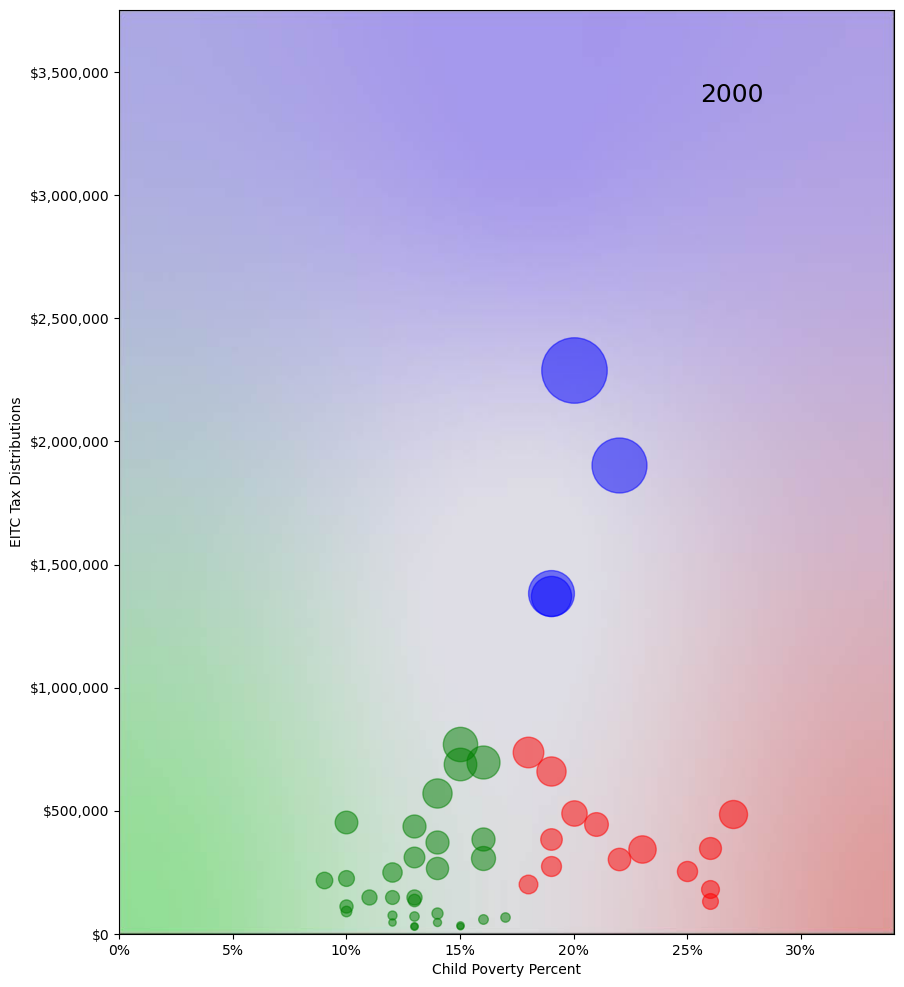

In [55]:
Eased(result_df).scatter_animation2d(dot_colors=dot_colors,bub_size = bub_size, speed=0.2,label=True,plot_kws=params,destination='testy.gif', background_image_path = bg_img)

In [79]:


# Load the existing GIF file
input_gif_path = 'testy.gif'
output_gif_path = 'EITC_STORY.gif'

with Image.open(input_gif_path) as gif:
    frames = []

    for frame_index in range(gif.n_frames):
        gif.seek(frame_index)
        frame = gif.copy()

        # Add annotation to the frame
        draw = ImageDraw.Draw(frame)

        # Calculate center coordinates (replace with your logic)
        title_x = frame.width // 6
        title_y = frame.height // 5.5
        circle_x = frame.width // 1.85
        circle_y = frame.height // 1.1858
        
        size_key_x = frame.width // 1.3
        size_key_y = frame.width // 3
        
        rad_1 = 30
        rad_2 = 15
        rad_3 = 5

        draw.ellipse((size_key_x - rad_1, size_key_y - rad_1,
                      size_key_x + rad_1, size_key_y + rad_1), outline='black')
        draw.ellipse((size_key_x - rad_2, size_key_y - rad_2,
                      size_key_x + rad_2, size_key_y + rad_2), outline='black')
        
        ##draw text that xxx children in poverty
        
        # draw.ellipse((size_key_x - rad_3, size_key_y - rad_3,
        #               size_key_x + rad_3, size_key_y + rad_3), outline='black')
        
        
        font_size = 32
        font = ImageFont.truetype("arial.ttf", font_size, encoding="unic") 
        draw.text((title_x, title_y), 'Wisconsin bucks the national trend', fill='black', font=font)

        elipse_height = 26
        elipse_width = 66
        draw.ellipse((circle_x - elipse_width, circle_y - elipse_height,
                      circle_x + elipse_width, circle_y + elipse_height), outline='black')

        # Append the annotated frame to the list
        frames.append(frame)

# Save the modified frames as a new GIF file
frames[0].save(output_gif_path, save_all=True, append_images=frames[1:], duration=gif.info['duration'], loop=0)
